# Tracer test in a fluvial aquifer

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
import sys
import shutil
from joblib import Parallel, delayed
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import flopy
import geone
import pickle
import time
from fluvial import FluvialSimulation
from tracer import TracerTest
%aimport fluvial, tracer

In [3]:
COLOR_SCHEME = [ 
        [x/255 for x in [166,206,227]],
        [x/255 for x in [31,120,180]],
        [x/255 for x in [178,223,138]],
        [x/255 for x in [51,160,44]],
        ]
LEGEND = ['silt', 'fine sand', 'coarse sand', 'gravel']
LEGEND = ['1', '2', '3', '4']
FONT_SIZE = 8
DPI = 300
FIG_DIR = 'figures'

## DeeSse simulation

In [4]:
fluvial_simulation = FluvialSimulation(nthreads=8)

The original training image is the one generated with Flumy and then used by Christoph:
https://www.frontiersin.org/articles/10.3389/feart.2018.00203/full

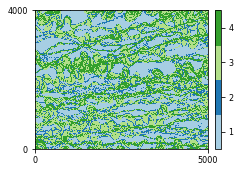

In [5]:
plt.figure(figsize=(3.34645669,3.34645669))
geone.imgplot.drawImage2D(fluvial_simulation.ti_original,
                          categ=True,
                          categCol=COLOR_SCHEME,
                          cticklabels=LEGEND,
                          cticklabels_fontsize=FONT_SIZE,
                          xlabels_fontsize=FONT_SIZE,
                          ylabels_fontsize=FONT_SIZE,
                          xticks=[0, 5000],
                          yticks=[0, 4000],
                          xticklabels = [0, 5000],
                          yticklabels = [0, 4000],
                          xticklabels_fontsize=FONT_SIZE,
                          yticklabels_fontsize=FONT_SIZE,
                          )
plt.savefig(f'{FIG_DIR}/ti.eps', dpi=DPI)

### The reference field

The cell size is 5 m by 5 m and the field is 0.5 km x 0.5 km.

Conductivity, porosity, specific storage:  
Facies 4: 1e-1, 0.25, 1e-5  
Facies 3: 1e-3, 0.30, 1e-4  
Facies 2: 1e-4, 0.35, 5e-4  
Facies 1: 1e-5, 0.40, 1e-3  

In [6]:
try:
    with open('ref/ref-img.pickle', 'rb') as file_handle:
        ref = pickle.load(file_handle)
except:
    ref = fluvial_simulation.generate_with_hd(i=-101)
    with open('ref/ref-img.pickle', 'wb') as file_handle:
        pickle.dump(ref, file_handle)

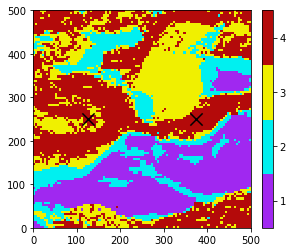

In [7]:
geone.imgplot.drawImage2D(ref, categ=True)
plt.scatter([125, 375], [250, 250], marker='x', c='black', s=150)

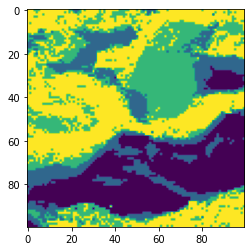

In [8]:
img = fluvial_simulation.get_plain_image(ref)
plt.imshow(img)

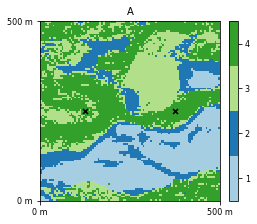

In [9]:
plt.figure(figsize=(3.54330709,3.54330709))
geone.imgplot.drawImage2D(ref,
                          categ=True,
                          categCol=COLOR_SCHEME,
                          cticklabels=LEGEND,
                          cticklabels_fontsize=FONT_SIZE,
                          xlabels_fontsize=FONT_SIZE,
                          ylabels_fontsize=FONT_SIZE,
                          xticks=[0, 500],
                          yticks=[0, 500],
                          xticklabels = ['0 m', '500 m'],
                          yticklabels = ['0 m', '500 m'],
                          xticklabels_fontsize=FONT_SIZE,
                          yticklabels_fontsize=FONT_SIZE,
                          title='A',
                          title_fontsize=10,
                          )
plt.scatter([125, 375], [250, 250], marker='x', c='black', s=25)
#plt.tight_layout()
plt.savefig(f'{FIG_DIR}/ref.eps', dpi=DPI)

## Tracer test

The injection well is placed at position (125 m, 250 m) and the pumping well at (275 m, 250 m), so 250 m apart.
 
MODFLOW first solves for steady state with pumping well on (without any injeciton), then performs transient simulation with injection. After 1h injection is over and transient simulation is continued with the pumping well always on.

Boundary-conditions: no-flow on north and south, 0.5 m west (left boundary), 0 , east (right boundary).

Pumping: $0.07 m^3/s = 70 l/s$ (considered steady-state)  
Injection: $1/3600 m^3/s = 10/36 l/s = 1 m^3/h$ during 1h


Concentration is constant in the injected water: $1 kg/m^3$, so a total of 1 kg of tracer are flushed into the well.

Discretization:  
-  1m x 1m, 5 times finer than the k-field 
-  temporal: 36 steps during 1 h injection, 240 steps during tracer test (1 step per 2 h)

Time: 1 h + 20 days

Dispersion: $\alpha_L = 4 m$, $\alpha_T = 0.1 \alpha_L$  
Molecular diffusion: $1\cdot10^{-9}$





In [10]:
steps_factor = 4
tracer_test = TracerTest(steps_factor=steps_factor, reference_run=True, working_dir='reference-modflow')

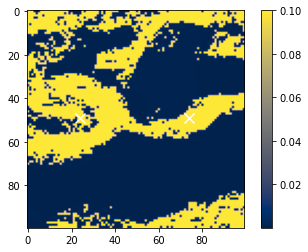

In [11]:
k = tracer_test.get_k(img)
plt.imshow(k, cmap='cividis')
plt.colorbar()
plt.scatter([24, 74], [49, 49], marker='x', c='white', s=100)

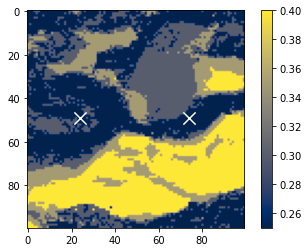

In [12]:
porosity = tracer_test.get_porosity(img)
plt.imshow(porosity, cmap='cividis')
plt.colorbar()
plt.scatter([24, 74], [49, 49], marker='x', c='white', s=150)

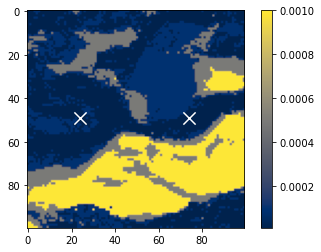

In [13]:
ss = tracer_test.get_specificstorage(img)
plt.imshow(ss, cmap='cividis')
plt.colorbar()
plt.scatter([24, 74], [49, 49], marker='x', c='white', s=150)

In [14]:
# if heads can be read we suppose the simulation was ok
name = f'ref-tracer-{steps_factor}'
try:
    hds = tracer_test.get_heads(name=name)
except:
    tracer_test.run(img=img, name=name)
    hds = tracer_test.get_heads(name=name)

In [15]:
inj_y, inj_x = tracer_test.injection_well()
pump_y, pump_x = tracer_test.pumping_well()

Text(0.5, 1.0, 'Heads without any pumping')

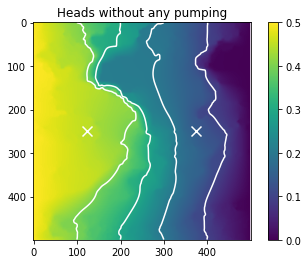

In [16]:
plt.imshow(hds[0,0,:,:])
plt.colorbar()
plt.contour(hds[0,0,:,:], levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5], colors='white')
plt.scatter(x=[inj_x, pump_x], y=[inj_y, pump_y], marker='x', color='white', s=100)
plt.title("Heads without any pumping")

Text(0.5, 1.0, 'Heads with pumping well')

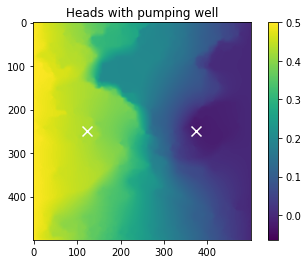

In [17]:
plt.imshow(hds[1,0,:,:])
plt.colorbar()
plt.scatter(x=[inj_x, pump_x], y=[inj_y, pump_y], marker='x', color='white', s=100)
plt.title("Heads with pumping well")

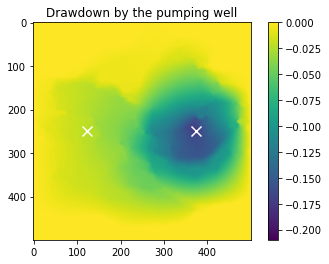

In [18]:
plt.title("Drawdown by the pumping well")
plt.imshow(hds[1,0,:,:]-hds[0,0,:,:])
plt.colorbar()
plt.scatter(x=[inj_x, pump_x], y=[inj_y, pump_y], marker='x', color='white', s=100)

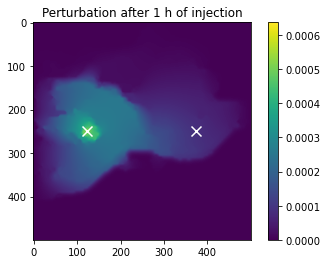

In [19]:
plt.title("Perturbation after 1 h of injection")
plt.imshow(hds[2,0,:,:]-hds[1,0,:,:])
plt.colorbar()
plt.scatter(x=[inj_x, pump_x], y=[inj_y, pump_y], marker='x', color='white', s=100)

## Budget

In [20]:
df = tracer_test.get_budget(name=name)

reference-modflow/modflow/ref-tracer-4/gwf_ref-tracer-4.lst


In [21]:
df[0][['CHD_IN', 'TOTAL_IN', 'WEL_OUT', 'TOTAL_OUT']]

,CHD_IN,TOTAL_IN,WEL_OUT,TOTAL_OUT
1970-01-01 00:00:01,0.2246,0.2246,0.00,0.2246
1970-01-01 00:00:02,0.2521,0.2521,0.07,0.2521
1970-01-01 01:00:02,0.2518,0.2521,0.07,0.2521
1970-01-21 01:00:00,0.2521,0.2521,0.07,0.2521


The first line of budget is without pumping at all and the second is steady-state solution with pumping well (on injection). The units are in $m^3/s$, so $30 l/s = 1800 l/min$ are pumped in the well.

In [22]:
times_conc = tracer_test.get_times_conc(name=name, loc_list = [(0, inj_y, inj_x), (0, pump_y, pump_x)])

## Concentration in h

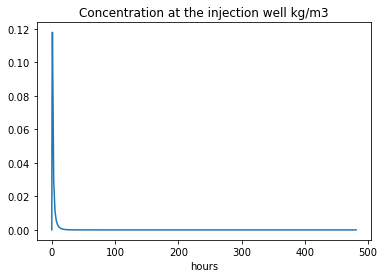

In [23]:
plt.title("Concentration at the injection well kg/m3")
plt.xlabel("hours")
plt.plot(times_conc[:,0]/3600, times_conc[:,1])

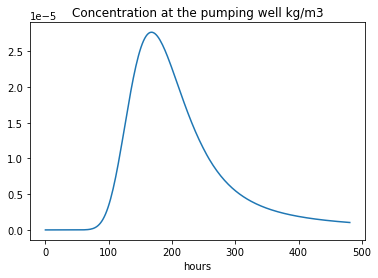

In [24]:
plt.title("Concentration at the pumping well kg/m3")
plt.xlabel("hours")
plt.plot(times_conc[:,0]/3600, times_conc[:,2])

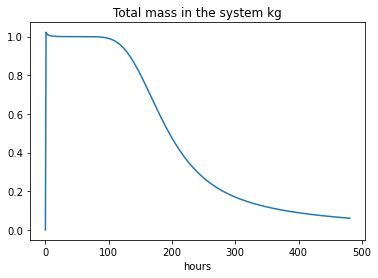

In [25]:
times = tracer_test.get_times(name=name)
concentrations = tracer_test.get_concentrations(name=name)

# Total mass of tracer present in the system
total_mass= [np.sum(concentrations[x,0,:,:]*10*np.repeat(np.repeat(porosity, 5, axis=0),5,axis=1))
      for x in range(concentrations.shape[0])]
plt.title("Total mass in the system kg")
plt.xlabel("hours")
plt.plot(np.array(times)/3600, total_mass[:])

## Adjust timestep

In [26]:
def concentration_curve(nb_steps):
    tracer_test = TracerTest(steps_factor=nb_steps, working_dir=f'./modflow-{nb_steps}/', reference_run=True)
    workspace = f'conv{nb_steps}'
    tracer_test.run(img=img, name=workspace)
    inj = tracer_test.injection_well()
    pump = tracer_test.pumping_well()
    times_conc = tracer_test.get_times_conc(loc_list = [(0, *inj), (0, *pump)], name=workspace)
    return times_conc

In [27]:
parameters = [1, 2, 4, 8, 16]

In [28]:
try:
    with open('ref/convergence-results.pickle', 'rb') as fh:
        results = pickle.load(fh)
except FileNotFoundError:
    results = Parallel(n_jobs=5)(delayed(concentration_curve)(p) for p in parameters)
    with open('ref/convergence-results.pickle', 'wb') as fh:
        pickle.dump(results, fh)

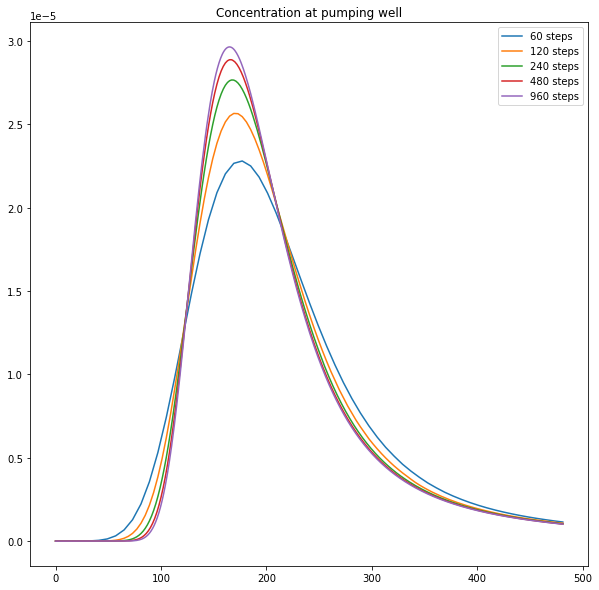

In [29]:
plt.figure(figsize=(10,10))
plt.title("Concentration at pumping well")
for times_conc in results:
    plt.plot(times_conc[:,0]/3600, times_conc[:,2])
plt.legend([f'{p*60} steps' for p in parameters])

### Observation:

In [30]:
# add random noise with std of 5% of current measured value
rng = np.random.default_rng(1234)
gaussian_noise = rng.normal(0, 0.05e-5, concentrations[:,:,pump_y,pump_x].shape)

In [31]:
# make sure non-negative
measurement = concentrations[:,:,pump_y,pump_x] + gaussian_noise
measurement[measurement<0] = 0

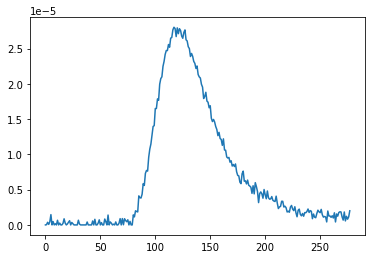

In [32]:
# looks noisy but ok
plt.plot(measurement)

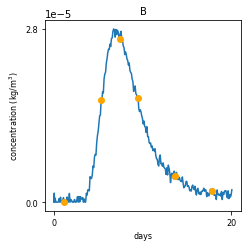

In [33]:
plt.figure(figsize=(3.54330709,3.54330709))
ind = [50,100, 125, 150, 200, 250]
plt.xticks([0,20], size=8)
plt.yticks([0,2.8e-5],size=8)
plt.ylabel("concentration (kg/m$^3$)", size=8)
plt.xlabel("days", size=8)
#plt.yticklabels(['0','6'])
#plt.xticklabels_fontsize(FONT_SIZE)
#plt.yticklabels_fontsize(FONT_SIZE)
plt.title('B', size=10)
plt.plot(np.array(times)/3600/24, measurement, zorder=-1)

plt.scatter((np.array(times)/3600/24)[ind], measurement[ind], c='orange', zorder=1)
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/measurement.eps', dpi=DPI)

In [34]:
# save the measurement
with open(f'ref/measurement-{steps_factor}.pickle', 'wb') as file_handle:
    pickle.dump(measurement, file_handle)

In [35]:
# save the measurement
with open(f'ref/times.pickle', 'wb') as file_handle:
    pickle.dump(times, file_handle)

## Plot tracer concentration over time

In [36]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation

<IPython.core.display.Javascript object>


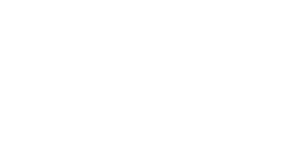

In [37]:
# show concentration over time
fig = plt.figure()
ax = plt.axes()
line, = ax.plot([],[],lw=2)
im=plt.imshow(concentrations[36,0,:,:], cmap='cividis', vmin=0, vmax=np.max(concentrations[:,:, pump_y, pump_x]))
plt.colorbar()
plt.scatter([inj_x, pump_x], [inj_y, pump_y], marker='x', s=20, color='white')

def init():
    im.set_data(concentrations[36,0,:,:])
    return [im]

def animate(i):
    ax.set_title('{} days'.format(int(i/(12))))
    im.set_array(concentrations[36+i,0,:,:])
    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=240, interval=10, blit=True)

## Prediction of 20 days zone

Is based on steady-state solution with the pumping well on and forward particle tracking (MODPATH).
What I find disturbing is that the injection well is not included in the 10-day zone. However, the tracer test depends on how the tracer diffuses and 10-day zone (if I understand it correctly) takes into account the "age" of groundwater

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

In [39]:
name_mp = 'modpath'
tracer_test_mp = TracerTest(steps_factor=4, cell_divisions=1, working_dir='reference-modpath')

In [40]:
try:
    with open(tracer_test_mp.zone_file(name=name_mp), 'rb') as file_handle:
        zone = pickle.load(file_handle)
except:
    tracer_test_mp.predict(name=name_mp, img=img)
    with open(tracer_test_mp.zone_file(name=name_mp), 'rb') as file_handle:
        zone = pickle.load(file_handle)

## The 10 days zone

(0.0, 500.0)

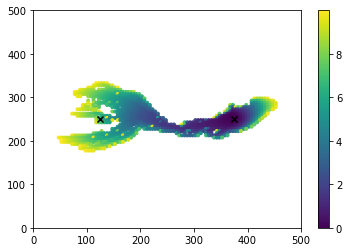

In [41]:
plt.scatter(zone['x0'], zone['y0'], c=zone['time']/3600/24, marker='.')
plt.colorbar()
plt.scatter([125,375], [250,250], marker='x', c='black')
plt.xlim([0,500])
plt.ylim([0,500])

In [42]:
name_mp_transient = 'mp_trans'
tracer_test_mp_transient = TracerTest(steps_factor=4, cell_divisions=1, working_dir='reference-modpath-transient')

In [43]:
try:
    with open(tracer_test_mp.zone_file(name=name_mp_transient), 'rb') as file_handle:
        zone_tracer = pickle.load(file_handle)
except:
    tracer_test_mp.predict(name=name_mp_transient, img=img)
    with open(tracer_test_mp.zone_file(name=name_mp_transient), 'rb') as file_handle:
        zone_tracer = pickle.load(file_handle)

CPU times: user 257 µs, sys: 206 µs, total: 463 µs
Wall time: 501 µs


(0.0, 500.0)

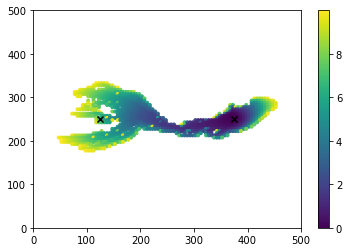

In [44]:
plt.scatter(zone_tracer['x0'], zone_tracer['y0'], c=zone_tracer['time']/3600/24, marker='.')
plt.colorbar()
plt.scatter([125,375], [250,250], marker='x', c='black')
plt.xlim([0,500])
plt.ylim([0,500])

## The 5 days zone

In [45]:
zone = tracer_test_mp.get_forward_track(name=name_mp, days=5)

(0.0, 500.0)

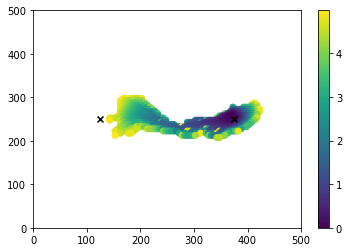

In [46]:
plt.scatter(zone['x0'], zone['y0'], c=zone['time']/3600/24)
plt.colorbar()
plt.scatter([125,375], [250,250], marker='x', c='black')
plt.xlim([0,500])
plt.ylim([0,500])